![title](https://i.ibb.co/f2W87Fg/logo2020.png)

---


<table  class="tfo-notebook-buttons" align="left"><tr><td>
    
<a href="https://colab.research.google.com/github/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 16 - Object Segmentation.ipynb" source="blank" ><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>
</td><td>
<a href="https://github.com/adf-telkomuniv/CV2020_Exercises/blob/main/CV2020 - 16 - Object Segmentation.ipynb" source="blank" ><img src="https://i.ibb.co/6NxqGSF/pinpng-com-github-logo-png-small.png"></a>
    
</td></tr></table>


# Task 16 - Object Segmentation

<br>

In this exercise, we will build a simplified version of Image segmentation model using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>, that trained from scratch on the Oxford Pets dataset


## What is image segmentation?
So far you have tried image classification, where the task of the network is to assign a label or class to an input image, and a little of object detection, where the task is to assign class and determine the object's location. 

However, suppose now we want to know not only where an object is located in the image, but also the shape of that object, and which pixel belongs to which object. 

In this case what we need is to to segment the image, i.e., each pixel of the image is given a label. 

<center><img src="https://i.ibb.co/8XBwgS0/CV-Tasks.png" width="80%"></center>

<br>

The task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.


Write down your Name and Student ID

In [1]:
## --- start your code here ----

NIM  = 1301170073
Nama = 'Pratama Yoga S'

## --- end your code here ----

---
---
#[Part 0] Import Libraries 

---
## 1 - Import Module

import the necessary modules

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.image import resize, flip_left_right

from tensorflow.keras import Model, Input, backend
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPool2D, UpSampling2D, ReLU
from tensorflow.keras.layers import Activation, BatchNormalization, add

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import plot_model



---
## 2 - Helper Functions

Various helper functions for visualization

### Display Images
Function to display a set of image : 
* input image, 
* it's ground truth segmentation mask, and 
* the model's mask prediction

In [2]:
def display(image_list):
  plt.figure(figsize=(5*len(image_list), 5))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(image_list)):
    plt.subplot(1, len(image_list), i+1)
    plt.title(title[i])
    plt.imshow(array_to_img(image_list[i]))
    plt.axis('off')
  plt.show()

### Plot History
Function to plot the train/val loss and accuracy history

In [3]:
def plot_my_history(history):
  plt.rcParams['figure.figsize'] = [14, 3.5]
  plt.subplots_adjust(wspace=0.2)

  plt.subplot(121)
  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])

  plt.subplot(122)
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'])
  plt.show()

---
---
#[Part 1] Oxford-IIIT Pets dataset


The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.

<center><img src="https://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg" width="80%"></center>

https://www.robots.ox.ac.uk/~vgg/data/pets/


---
## 1 - Download Dataset


The dataset is already included in TensorFlow datasets, all that is needed to do is download it. The segmentation masks are included in version 3+.

In [4]:
dataset, ds_info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

---
## 2 - View Dataset
Now let's take a look at the dataset details. Here we use the `tfds.as_dataframe()` function to view the dataset  a pandas dataframe.

However, you should see that the `segmentation_mask` is just a black box of image. This happen because the mask is just a label of `{1,2,3}`, which just result in black images if we tried to display it raw

,file_name,image,label,segmentation_mask,species
0,Sphynx_158.jpg,,33 (Sphynx),,0 (Cat)
1,english_cocker_spaniel_135.jpg,,12 (english_cocker_spaniel),,1 (Dog)
2,British_Shorthair_181.jpg,,9 (British_Shorthair),,0 (Cat)
3,Siamese_161.jpg,,32 (Siamese),,0 (Cat)

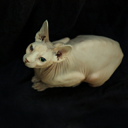
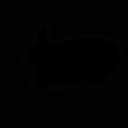
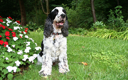
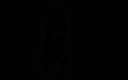
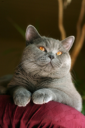
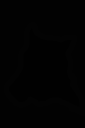
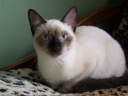
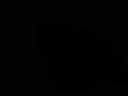

In [5]:
tfds.as_dataframe(dataset['train'].take(4), ds_info)


---
## 3 - View Segmentation Mask

For that, we use the other `tfds` visualization method, which is `tfds.show_examples()`.

Now you should be able to see the segmentation mask visualizations

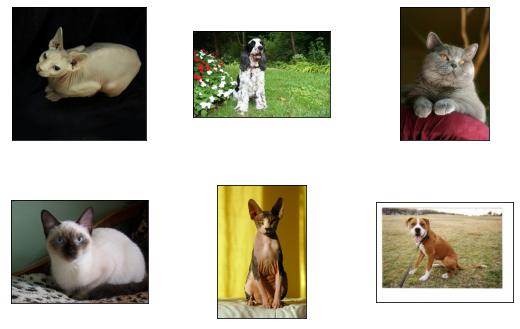

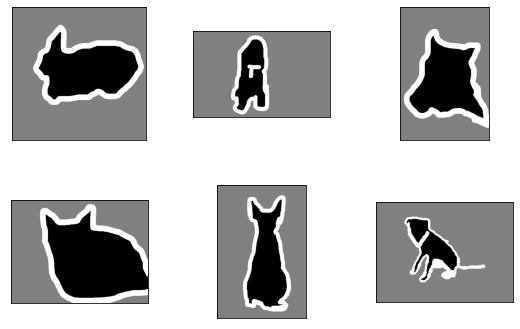

In [6]:
fig1 = tfds.show_examples(dataset['train'].take(6), ds_info, image_key='image')
fig2 = tfds.show_examples(dataset['train'].take(6), ds_info, image_key='segmentation_mask')


---
## 4 - Data Augmentation

Here, we will define a function to perform a simple augmentation of flipping an image. In addition, image is normalized to `[0,1]`. 

Finally, as mentioned above the pixels in the segmentation mask are labeled either `{1, 2, 3}`. For the sake of convenience, let's subtract 1 from the segmentation mask, resulting in labels that are : `{0, 1, 2}`.

---
#### <font color='red'>**EXERCISE:** </font>

Complete the Augmentation function.

Use the `flip_left_right()` and `resize()` function from the `tensorflow.image` module to simpy resize the image to the desired size, then randomly mirror the trainset images along with its masks.


In [7]:
@tf.function
def load_image_train(datapoint):
    # resize image to the desired size
    # call resize() function with input datapoint['image'] and img_size
    input_image = resize(datapoint['image'], img_size)
    
    # call resize() function with input datapoint['segmentation_mask'] and img_size
    input_mask  = resize(datapoint['segmentation_mask'], img_size)

    # randomly horizontal flip the image and its mask
    if tf.random.uniform(()) > 0.5:
        # call flip_left_right() function with input input_image
        input_image = flip_left_right(input_image)

        # call flip_left_right() function with input input_image
        input_mask  = flip_left_right(input_image)

    # normalize input into [0,1] range
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

---
#### <font color='red'>**EXERCISE:** </font>

perform the same resizing and normalization process, but without the augmentation part for the testset images.


In [8]:
def load_image_test(datapoint):
    # resize image to the desired size
    # call resize() function with input datapoint['image'] and img_size
    input_image = resize(datapoint['image'], img_size)
    
    # call resize() function with input datapoint['segmentation_mask'] and img_size
    input_mask  = resize(datapoint['segmentation_mask'], img_size)

    # normalize input into [0,1] range (see implementation above)
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask  -= 1

    return input_image, input_mask

---
## 5 - Data Generator

Now let's build a data generator to preprocess (augment and normalize) the data in batches.

The dataset already contains the required splits of test and train and so let's continue to use the same split.

First we define the batch size and the image size

In [9]:
num_train       = ds_info.splits['train'].num_examples
img_size        = (160, 160)
num_classes     = 3
batch_size      = 64
buffer_size     = 1000
steps_per_epoch = num_train // batch_size

Then generate the train data generator

In [10]:
train_generator = dataset['train'].map(load_image_train, 
                                       num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset   = train_generator.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_dataset   = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Do the same for test set

In [11]:
test_generator = dataset['test'].map(load_image_test)

test_dataset   = test_generator.batch(batch_size)

Let's take a look at an image example and it's correponding mask from the dataset.

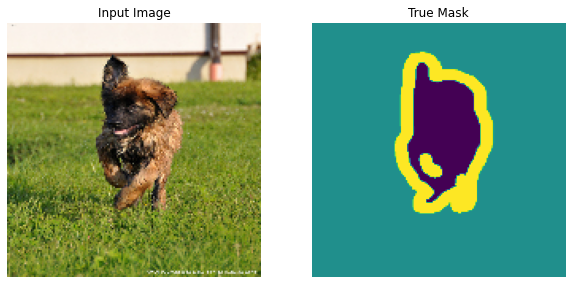

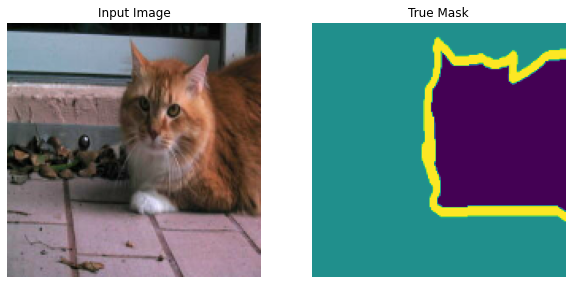

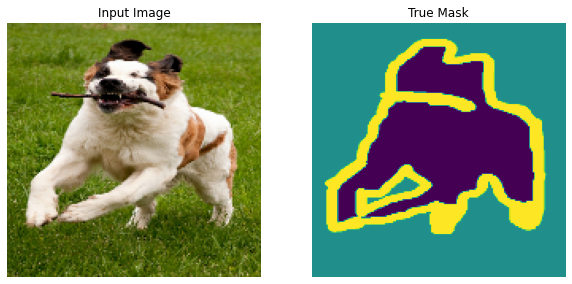

In [12]:
for image, mask in test_generator.take(3):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

---
---
# [Part 2] U-Net Architecture

The model being used here is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. 
<center><img src="https://zslpublications.onlinelibrary.wiley.com/cms/asset/ee790e9d-99bd-4cc4-8a92-c9d6c52cc1b3/rse2111-fig-0004-m.jpg" width="80%"></center>

But here we're not going to use the original U-Net architecture. Here we're going to build a smaller U-Net-like architecture using Xception architecture as the base.


---
## 1 - U-Net Encoder
Our Encoder Model will consist of several blocks of identical convolution layer with different filter size to extract feature at different depth. 

Here we will build the Blocks and the Encoder itself in separate models to make them easier to build and understand.


### a. Encoder Block

Now define the model builder for an Encoder block of a filter size.

Each block consist of two sub-block of:
* Relu Activation
* $3\times3$ Separable Convolution, and
* Batch Normalization Layer

The sub-blocks are followed by a $3\times3$ stride $2$ Max Pooling Layer.

The block is then added with a residual connection of <br> $1\times1$ stride $2$ Conv2D received from the input block

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above. 

Remember, here we use the Functional API model building.

hint: use Activation() layer for relu


In [13]:
def build_encoder_block(input_shape, filters):

    # define the input block as input_shape
    block_input = Input(shape=input_shape)

    # Sub-block 1
    # add relu activation after block_input
    x = Activation(activation='relu')(block_input)
    # add SeparableConv2D() with input filters, kernel_size, and padding='same' after x
    x = SeparableConv2D(filters, kernel_size=3, padding='same')(x)
    # add Batch Normalization after x
    x = BatchNormalization()(x)

    # Sub-block 2
    # add relu activation after x
    x = Activation(activation='relu')(x)
    # add SeparableConv2D() with input filters, kernel_size, and padding='same' after x
    x = SeparableConv2D(filters, kernel_size=3, padding='same')(x)
    # add Batch Normalization after x
    x = BatchNormalization()(x)

    # add MaxPool2D with input pool_size, strides, and padding='same' after x
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

    # Project residual from input
    # add Conv2D with input filters, kernel_size=1, stride=2, and padding='same' after block_input
    residual = Conv2D(filters, kernel_size=1, strides=2, padding='same')(block_input)

    # Add x and residual as output
    block_output = add([x, residual])  

    # instantiate model from block_input to block_output
    block_model = Model(block_input, block_output, name='enc_block_'+str(filters))

    return block_model

Check your implementation

In [14]:
filters       = 32
input_shape   = (28, 28, 1)
encoder_block = build_encoder_block(input_shape, filters)

Print the Summary

In [15]:
encoder_block.summary()

Model: "enc_block_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 28, 28, 32)   73          activation[0][0]                 
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 32)   128         separable_conv2d[0][0]           
_______________________________________________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "enc_block_32"
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_? (InputLayer)            [(None, 28, 28, 1)]  0                                            
activation_? (Activation)       (None, 28, 28, 1)    0           input_?[0][0]                    
separable_conv2d_? (SeparableCo (None, 28, 28, 32)   73          activation_?[0][0]                 
batch_normalization_? (BatchNor (None, 28, 28, 32)   128         separable_conv2d_?[0][0]           
...
max_pooling2d_? (MaxPooling2D)  (None, 14, 14, 32)   0           batch_normalization_?[0][0]      
conv2d_? (Conv2D)               (None, 14, 14, 32)   64          input_1[0][0]                    
add_? (Add)                     (None, 14, 14, 32)   0           max_pooling2d[0][0]              
                                                                 conv2d[0][0]                     
==================================================================================================
Total params: 1,737
Trainable params: 1,609
Non-trainable params: 128

Let's also visualize the model

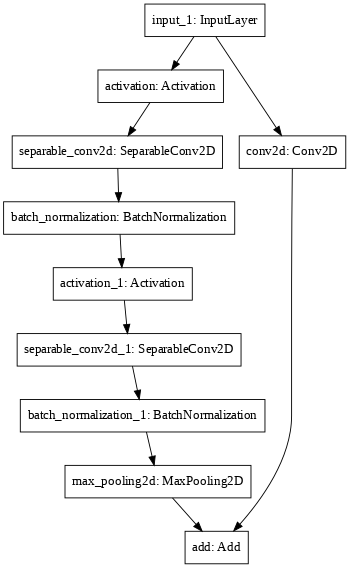

In [16]:
plot_model(encoder_block, dpi=65)

**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/5WhqZG9/unet-enc-block.png" height=400>

### b. Encoder Model
Now we're done with the Encoder Block, let's define the Encoder Model builder function

The builder function receives a list of filters, and iteratively builds and stacks a block for each filter size

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above. 

Remember, here we use the Functional API model building.


In [17]:
def build_encoder_model(input_shape, filter_list):

    # define the input model as input_shape
    encoder_input = Input(shape=input_shape)

    # store input as x for iterative purpose
    x = encoder_input

    # loop for each filter
    for filters in filter_list:
        # call build_encoder_block function with input input_shape and filters
        encoder_block = build_encoder_block(input_shape, filters)

        # stack new encoder_block to x
        x = encoder_block(x)

        # get the last block output shape 
        input_shape = encoder_block.output.shape[1:]

    # get the encoder output
    encoder_output = x
    
    # instantiate model from encoder_input to encoder_output
    encoder_model = Model(encoder_input, encoder_output, name='encoder_model')
    
    return encoder_model
    

Check your implementation

In [18]:
filter_list   = [64, 128, 256]
input_shape   = (56, 56, 1)
encoder_model = build_encoder_model(input_shape, filter_list)

Print the Summary

In [19]:
encoder_model.summary()

Model: "encoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
enc_block_64 (Functional)    (None, 28, 28, 64)        5513      
_________________________________________________________________
enc_block_128 (Functional)   (None, 14, 14, 128)       35904     
_________________________________________________________________
enc_block_256 (Functional)   (None, 7, 7, 256)         137344    
Total params: 178,761
Trainable params: 176,969
Non-trainable params: 1,792
_________________________________________________________________


**EXPECTED OUTPUT**:
<pre>
Model: "encoder_model"
Layer (type)                 Output Shape              Param #   
=================================================================
input_? (InputLayer)         [(None, 56, 56, 1)]       0         
enc_block_64 (Functional)    (None, 28, 28, 64)        5513      
enc_block_128 (Functional)   (None, 14, 14, 128)       35904     
enc_block_256 (Functional)   (None, 7, 7, 256)         137344    
=================================================================
Total params: 178,761
Trainable params: 176,969
Non-trainable params: 1,792

Let's also visualize the model

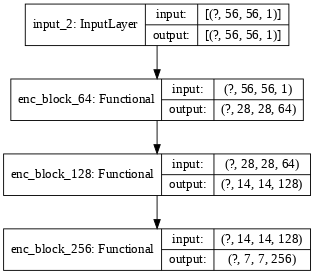

In [20]:
plot_model(encoder_model, show_shapes=True, dpi=65)

**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/4VvgrLv/unet-enc.png" height=250>

---
## 2 - U-Net Decoder
The Decoder model will consist of several blocks with identical transpose convolution layer with different filter size to reconstruct feature at different depth. These blocks are similar but mirrored of the Encoder blocks.

Again, we will build the Blocks and the Decoder itself in separate models to make them easier to build and understand.


###a. Decoder Block

Now define the model builder for a Decoder block of a filter size.

Each block, again, consist of two sub-blocks of:
* Relu Activation
* $3\times3$ Transpose Convolution, and
* Batch Normalization Layer

The sub-blocks are followed by a $2\times2$ UpSampling3D layer. Then added with a residual connection of <br> $1\times1$ Conv2D received from  the input block

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above. 

Remember, here we use the Functional API model building.

hint: use Activation() layer for relu


In [21]:
def build_decoder_block(input_shape, filters):

    # define the input block as input_shape
    block_input = Input(shape=input_shape)

    # Sub-block 1
    # add relu activation after block_input
    x = Activation(activation='relu') (block_input)
    # add Conv2DTranspose() with input filters, kernel_size, and padding='same' after x
    x = Conv2DTranspose(filters, kernel_size=3, padding='same') (x)
    # add Batch Normalization after x
    x = BatchNormalization()(x)

    # Sub-block 2
    # add relu activation after x
    x = Activation(activation='relu') (x)
    # add Conv2DTranspose() with input filters, kernel_size, and padding='same' after x
    x = Conv2DTranspose(filters, kernel_size=3, padding='same') (x)
    # add Batch Normalization after x
    x = BatchNormalization()(x)

    # add UpSampling2D with input size=2 after x
    x = UpSampling2D(size=2)(x)

    # Project residual from input
    # add UpSampling2D with input size=2 after block_input
    residual = UpSampling2D(size=2 ) (block_input)
    # add Conv2D with input filters, kernel_size=1, and padding='same' after residual
    residual = Conv2D(filters, kernel_size=1, padding='same') (residual)

    # Add x and residual as output
    block_output = add([x, residual]) 

    # instantiate model from block_input to block_output
    block_model = Model(block_input, block_output, name='dec_block_'+str(filters))

    return block_model

Check your implementation

In [22]:
filters       = 32
input_shape   = (28, 28, 1)
decoder_block = build_decoder_block(input_shape, filters)

Print the Summary

In [23]:
decoder_block.summary()

Model: "dec_block_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 28, 28, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 28, 28, 32)   320         activation_8[0][0]               
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 28, 28, 32)   128         conv2d_transpose[0][0]           
_______________________________________________________________________________________

**EXPECTED OUTPUT**:
<pre>
Model: "dec_block_32"
Layer (type)                    Output Shape         Param #     Connected to     
==================================================================================================              
input_? (InputLayer)            [(None, 28, 28, 1)]  0                                            
activation_? (Activation)       (None, 28, 28, 1)    0           input_?[0][0]                    
conv2d_transpose_? (Conv2DTrans (None, 28, 28, 32)   320         activation_?[0][0]               
batch_normalization_? (BatchNor (None, 28, 28, 32)   128         conv2d_transpose_>[0][0]           
...        
up_sampling2d_? (UpSampling2D)  (None, 56, 56, 1)    0           input_?[0][0]                    
up_sampling2d_? (UpSampling2D)  (None, 56, 56, 32)   0           batch_normalization_?[0][0]      
conv2d_? (Conv2D)               (None, 56, 56, 32)   64          up_sampling2d_?[0][0]            
add_? (Add)                     (None, 56, 56, 32)   0           up_sampling2d_?[0][0]              
                                                                 conv2d_?[0][0]                   
==================================================================================================
Total params: 9,888
Trainable params: 9,760
Non-trainable params: 128

Let's also visualize the model

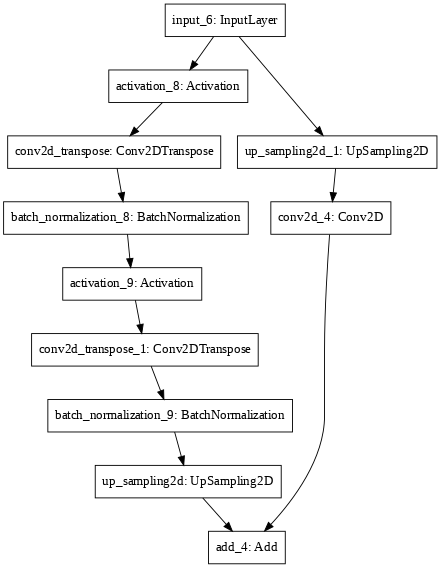

In [24]:
plot_model(decoder_block, dpi=65)

**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/PWwvTJM/unet-dec-block.png" height=400>

### b. Decoder Model
Now we're done with the Decoder Block, let's define the Decoder Model builder function

The builder function receives a list of filters, and iteratively builds and stacks a block for each filter size


---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above. 

Remember, here we use the Functional API model building.


In [25]:
def build_decoder_model(input_shape, filter_list):

    # define the input model as input_shape
    decoder_input = Input(shape=input_shape)

    # store input as x for iterative purpose
    x = decoder_input

    # loop for each filter
    for filters in filter_list:
        # call build_decoder_block function with input input_shape and filters
        decoder_block = build_decoder_block(input_shape, filters)

        # stack new decoder_block to x
        x = decoder_block(x)

        # get the last block output shape 
        input_shape = decoder_block.output.shape[1:]

    # get the decoder output
    decoder_output = x
    
    # instantiate model from decoder_input to decoder_output
    decoder_model = Model(decoder_input, decoder_output, name='decoder_model')

    return decoder_model
    

Check your implementation

In [26]:
filter_list   = [256, 128, 64]
input_shape   = (7, 7, 1)
decoder_model = build_decoder_model(input_shape, filter_list)

Print the Summary

In [27]:
decoder_model.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 7, 7, 1)]         0         
_________________________________________________________________
dec_block_256 (Functional)   (None, 14, 14, 256)       595200    
_________________________________________________________________
dec_block_128 (Functional)   (None, 28, 28, 128)       476544    
_________________________________________________________________
dec_block_64 (Functional)    (None, 56, 56, 64)        119488    
Total params: 1,191,232
Trainable params: 1,189,440
Non-trainable params: 1,792
_________________________________________________________________


**EXPECTED OUTPUT**:
<pre>
Model: "decoder_model"
Layer (type)                 Output Shape              Param #   
=================================================================
input_? (InputLayer)         [(None, 7, 7, 1)]         0         
dec_block_256 (Functional)   (None, 14, 14, 256)       595200    
dec_block_128 (Functional)   (None, 28, 28, 128)       476544    
dec_block_64 (Functional)    (None, 56, 56, 64)        119488    
=================================================================
Total params: 1,191,232
Trainable params: 1,189,440
Non-trainable params: 1,792

Let's also visualize the model

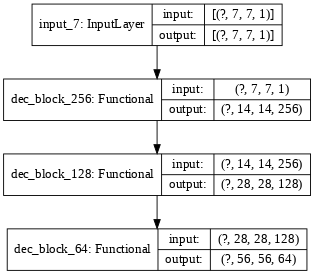

In [28]:
plot_model(decoder_model, show_shapes=True, dpi=65)

**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/hH8rQxs/unet-dec.png" height=250>

---
## 3 - U-Net Full

Now let's combine both the Encoder and Decoder into one complete U-Net Model

The Encoder receive an input from Entry block to perform downsampling of inputs, which consists of:
* $3\times3$, stride $2$, Conv2D Layer
* Batch Normalization Layer, and
* Relu Activation

While the output from the Decoder, will be added with the last Conv2D Layer $3\times3$ to draw the segmentation mask

---
#### <font color='red'>**EXERCISE:** </font>

Implement the function as defined above. 

Remember, here we use the Functional API model building.

hint: use Activation() layer for relu


In [33]:
def build_u_net(img_size, num_classes, e_filters, d_filters):

    # define the input model
    inputs = Input(shape=img_size + (3,))

    ### First half of the network: downsampling inputs ###
    # ----------1. Entry block -------------------------------------------------
    # add Conv2D with input filters=32, kernel_size=3, stride=2, and padding='same' after inputs
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(inputs)
    # add Batch Normalization after x
    x = BatchNormalization() (x)
    # add relu activation after x
    x =Activation(activation='relu') (x)

    # ----------2. Encoder blocks ----------------------------------------------
    # retrieve the output shape
    encoder_shape = x.shape[1:]
    # call build_encoder_model with input encoder_shape and e_filters
    encoder_model = build_encoder_model(encoder_shape, e_filters)
    # stack encoder_model to x
    x = encoder_model(x)


    ### Second half of the network: upsampling inputs ###
    # ----------3. Decoder blocks ----------------------------------------------
    # retrieve the output shape
    decoder_shape = x.shape[1:]
    # call build_decoder_model with input decoder_shape and d_filters
    decoder_model = build_decoder_model(decoder_shape, d_filters)
    # stack decoder_model to x
    x = decoder_model(x)

    # ----------4. per-pixel classification layer ------------------------------
    # add Conv2D with input filters=num_classes, kernel_size=3,
    #     activation='softmax', and padding='same' after x
    outputs = Conv2D(filters=num_classes, kernel_size=3, activation='softmax', padding='same') (x)

    # instantiate model from inputs to outputs
    model = Model(inputs, outputs, name='u-net')

    return model


##4 - Build Model

Now build our U-Net Model.

Let's use 3 blocks of encoder of `[64, 128, 256]` filters and 4 blocks of decoder of  `[256, 128, 64, 32]` filters. 

We use one less encoder block since in the Downsampling part of the network is already consist of an Entry block.

---
#### <font color='red'>**EXERCISE:** </font>

Build the model as defined above

you can try and change the number of filters

In [34]:
# Free up RAM in case the model definition cells were run multiple times
backend.clear_session()

# define the filters lists
e_filters = [64, 128, 256]
d_filters = [256, 128, 64, 32]

# call function to build the model
model = build_u_net(img_size, num_classes, e_filters, d_filters)

Check your implementation and print the Summary

In [35]:
model.summary()

Model: "u-net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 80, 80, 32)        0         
_________________________________________________________________
encoder_model (Functional)   (None, 10, 10, 256)       183008    
_________________________________________________________________
decoder_model (Functional)   (None, 160, 160, 32)      1874080   
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 160, 160, 3)       867   

**EXPECTED OUTPUT**:
<pre>
Model: "u-net"
Layer (type)                 Output Shape              Param #   
=================================================================
input_? (InputLayer)         [(None, 160, 160, 3)]     0         
conv2d_? (Conv2D)            (None, 80, 80, 32)        896       
batch_normalization_? (Batch (None, 80, 80, 32)        128       
activation_? (Activation)    (None, 80, 80, 32)        0         
encoder_model (Functional)   (None, 10, 10, 256)       183008    
decoder_model (Functional)   (None, 160, 160, 32)      1874080   
conv2d_? (Conv2D)            (None, 160, 160, 3)       867       
=================================================================
Total params: 2,058,979
Trainable params: 2,055,203
Non-trainable params: 3,776

Let's also visualize the model

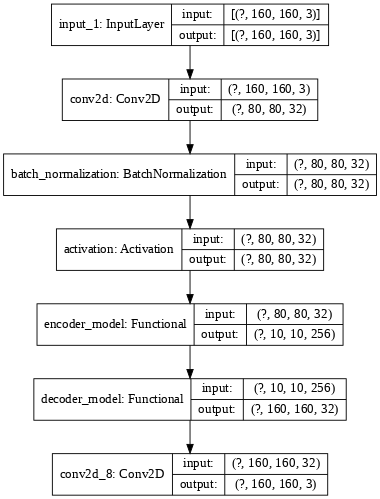

In [36]:
plot_model(model, show_shapes=True, dpi=65)

**EXPECTED OUTPUT**:

<img src="https://i.ibb.co/DzB8nCq/unet.png" height=400>

---
---
# [Part 3] Train Segmentation

Now, all that is left to do is to compile and train the model. The loss being used here is `sparse_categorical_crossentropy`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. 

In the true segmentation mask, each pixel has either a `{0,1,2}`. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `sparse_categorical_crossentropy` is the recommended loss for such a scenario. 


---
## 1 - Mask Visualization

Using the output of the network, the label assigned to the pixel is the channel with the highest value. 

This is what the `create_mask` function is doing.

In [37]:
def create_mask(pred_mask):

    # get class of max score from prediction
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

---
## 2 - Compile Model

---
#### <font color='red'>**EXERCISE:** </font>

compile model with `adam` or `rmsprop` optimizer with `sparse_categorical_crossentropy` loss and accuracy metric


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

---
## 3 - Visualize Prediction

Below is a function to convert the model prediction into mask visualization using previous `create_mask` function, and display it using `display` function

In [39]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


Let's try out the model to see what it predicts before training.

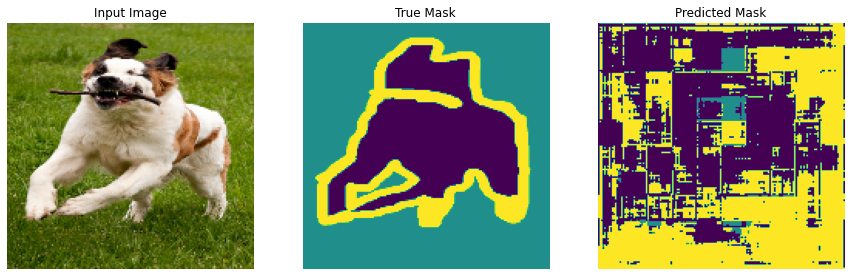

In [40]:
show_predictions()

You should see taht the prediction mask is all over the place

---
## 4 - DisplayCallback

Below is a keras callback to visualize the training progress every 5 epoch

In [41]:
class DisplayCallback(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs=None):
    if epoch%5 == 0:
        show_predictions()
        print ('Sample Prediction after epoch {}'.format(epoch+1))
        print ('loss: %0.4f - accuracy: %0.4f - val_loss: %0.4f - val_accuracy: %0.4f\n' % 
               (logs['loss'], logs['val_loss'], logs['accuracy'], logs['val_accuracy']))
        

---
## 5 - Train Model


---
#### <font color='red'>**EXERCISE:** </font>

Now train the model for 26 epochs. 

Train the model for a longer epoch to achieve more accurate results.



In [42]:
epochs   = 26
num_val  = 5
val_step = ds_info.splits['test'].num_examples//batch_size//num_val

model_history = model.fit(train_dataset, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=val_step,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()], verbose=0)

InvalidArgumentError: ignored

**EXPECTED OUTPUT**:
<pre>
the training loss should start around 2.0 and end around 0.1 after 26 epochs
with training accuracy start around 64% and end around 92%

Lets visualize the training history.

In [ ]:
plot_my_history(model_history)

---
## 6 - Make predictions

Let's make some predictions. 

In [ ]:
show_predictions(test_dataset, 3)


---

# Congratulation, You've Completed Exercise 16
<p>Copyright &copy;  <a href=https://www.linkedin.com/in/andityaarifianto/>2020 - ADF</a> </p>

![footer](https://i.ibb.co/yX0jfMS/footer2020.png)